In [1]:
import matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import csv
import random
import math
import tensorflow as tf
%matplotlib inline  

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
pelvic_incidence,1.000000,0.629199,0.717282,0.814960,-0.247467,0.638743
pelvic_tilt,0.629199,1.000000,0.432764,0.062345,0.032668,0.397862
lumbar_lordosis_angle,0.717282,0.432764,1.000000,0.598387,-0.080344,0.533667
sacral_slope,0.814960,0.062345,0.598387,1.000000,-0.342128,0.523557
pelvic_radius,-0.247467,0.032668,-0.080344,-0.342128,1.000000,-0.026065
degree_spondylolisthesis,0.638743,0.397862,0.533667,0.523557,-0.026065,1.000000


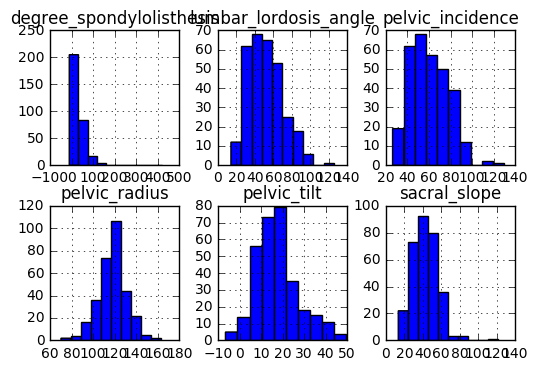

In [2]:
#Explore Features
df = pd.read_csv('column_3C_weka.csv')
df.hist(layout = (2, 3))
df.corr()

In [3]:
#FUNCTIONS

#preprocess/split data
def split_data_pandas(file_name, dev_train_sz = 0.2):
    data = pd.read_csv(file_name)
    data = shuffle(data)
    #print(data.shape)
    Y = data['class'].replace('Normal', 0).replace('Spondylolisthesis', 1).replace('Hernia', 2)
    X = data.drop('class', axis = 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = dev_train_sz)
    X_test, X_dev, Y_test, Y_dev = train_test_split(X_test, Y_test, test_size = .5)
    
    
    #print("train size is :" + str(X_train.shape) + str(Y_train.shape) )
    #print("test size is :" + str(X_test.shape) + str(Y_test.shape) )
    #print("dev size is :" + str(X_dev.shape) + str(Y_dev.shape) )
    #print(217+46+47)
    
    
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test


#load dfs -> numpy arrays  
load_data = lambda x: np.array(x)


#one-hot encode the Y numpy arrays
def one_hot(num_classes, y_data):
    num_classes = tf.constant(num_classes)
    hot_matrix = tf.one_hot(y_data, num_classes, axis = 1)
    session = tf.Session()
    hot = session.run(hot_matrix)
    session.close()
    return hot



In [4]:
#Generate df's with data (WRAP ALL THIS INTO A FUNCTION?)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_data_pandas('column_3C_weka.csv')

#load data into numpy arrays
X_data = load_data(X_train)
y_data = load_data(Y_train)
X_data = X_data
y_data = y_data.T

y_data = np.eye(3)[y_data]

X_dev_array = load_data(X_dev)
y_dev_array = load_data(Y_dev)
X_dev_array = X_dev_array
y_dev_array = y_dev_array.T

y_dev_array = np.eye(3)[y_dev_array]


print(X_data.shape)
print(y_data.shape)
print(X_dev_array.shape)
print(y_dev_array.shape)




print(tf.transpose(one_hot(3, y_data)))
print(tf.transpose(one_hot(3, y_dev_array)))

(248, 6)
(248, 3)
(31, 6)
(31, 3)
Tensor("transpose:0", shape=(3, 3, 248), dtype=float32)
Tensor("transpose_1:0", shape=(3, 3, 31), dtype=float32)


In [5]:
#Initialize Placeholders and Parameters
def init_ph(num_features, num_classes):
    '''
    Creates the X and Y training data placeholders
    '''

    X = tf.placeholder(tf.float32, shape = (num_features, None),name = 'X')
    Y = tf.placeholder(tf.float32, shape = (num_classes, None),name = 'Y')

    return X, Y

def init_param(num_hidden_layers, X_data, nodes = 30):
    '''
    Creates & initializes Weights and Biases parameters for layers
    '''
    
    #create appropriate variables
    Weights = {}
    Biases = {}
    
    for i in range(num_hidden_layers):
        if i == 0:
            num_ex = int(X_data.shape[1])
            wname = 'W_' + str(i)
            bname = 'B_' + str(i)
            Weights['W' + str(i)] = tf.get_variable(wname, shape = [nodes, num_ex], initializer = tf.contrib.layers.xavier_initializer())
            Biases['B' + str(i)] = tf.get_variable(bname, shape = [nodes, 1], initializer = tf.zeros_initializer())
        elif (i > 0) and (i < (num_hidden_layers)-1):
            wname = 'W_' + str(i)
            bname = 'B_' + str(i)
            Weights['W' + str(i)] = tf.get_variable(wname, shape = [nodes, nodes], initializer = tf.contrib.layers.xavier_initializer())
            Biases['B' + str(i)] = tf.get_variable(bname, shape = [nodes, 1], initializer = tf.zeros_initializer())
        else:
            wname = 'W_' + str(i)
            bname = 'B_' + str(i)
            Weights['W' + str(i)] = tf.get_variable(wname, shape = [3, nodes], initializer = tf.contrib.layers.xavier_initializer())
            Biases['B' + str(i)] = tf.get_variable(bname, shape = [3, 1], initializer = tf.zeros_initializer())
        
            
        
        
        
    return Weights, Biases
    
#X, Y = init_ph(X_data, y_data)
#W, B = init_param(3, X_data)
print("DONE")

DONE


In [6]:
#Computational Graph


#MAKE num_hidden_layers a global variable so its passed to both forward_prop and the init_param fucnctions
def forward_prop(X, Weights, Biases, num_hidden_layers):
    
    #store stuff for the loop
    Zs = {}
    As = {}
    last_layer = None
    
    for i in range(num_hidden_layers):
        #print(range(num_hidden_layers))
        zname = "Z_" + str(i)
        aname = "A_" + str(i)
        
        if i == 0:
            zname = tf.add(tf.matmul(Weights["W" + str(i)], X), Biases["B" + str(i)])
            Zs["Z" + str(i)] = zname
            aname = tf.nn.relu(Zs["Z" + str(i)])
            As["A" + str(i)] = aname
            
        elif (i > 0) and (i < (num_hidden_layers)-1):
            zname = tf.add(tf.matmul(Weights["W" + str(i)], As["A" + str(i-1)]), Biases["B" + str(i)])
            Zs["Z" + str(i)] = zname
            aname = tf.nn.relu(Zs["Z" + str(i)])
            As["A" + str(i)] = aname
        else:
            #print("output layer")
            last_layer = tf.add(tf.matmul(Weights["W" + str(i)], As["A" + str(i-1)]), Biases["B" + str(i)])
            
    
    return last_layer

#last_z = forward_prop(X, W, B, 3)
#print(last_z)
    
    
    
def cost_compute(last_z, Y):
    '''
    Calculate cost
    '''
    
    logits = tf.transpose(last_z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost
    
    
    
#cost = cost_compute(last_z, Y)
#print(cost)



In [7]:
#Wrapping around the relevant functions and data
def model(num_hidden_layers, X_data, y_data, x_dev_array, y_dev_array, nodes, learning_rate = 0.0001):
    
    #Initialize Placeholders
    X, Y = init_ph(X_data.shape[1], y_data.shape[1])
    
    #Initialize Weights/Biases
    W, B = init_param(num_hidden_layers, X_data, nodes)
    
    #Forward Propagation
    last_z = forward_prop(X, W, B, num_hidden_layers)
    print(last_z)
    
    #Compute Cost
    cost = cost_compute(last_z, Y)
    
    #Backprop
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    with tf.Session() as sess:
        
        #Initialize variables
        sess.run(tf.global_variables_initializer())
        
        sess.run([optimizer, cost], feed_dict={X: X_data.T , Y: y_data.T})
        
        #Save parameters
        Weights = sess.run(W)
        Biases = sess.run(B)

        #Calculate correct predictions
        corrects = tf.equal(tf.argmax(last_z), tf.argmax(Y))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(corrects, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_data.T, Y: y_data.T}))
        print ("Test Accuracy:", accuracy.eval({X: X_dev_array.T, Y: y_dev_array.T}))
        
        return W, B
        

In [8]:
#Run session/model
W, B = model(200, X_data, y_data, X_dev_array, y_dev_array, 9)

Tensor("Add_199:0", shape=(3, ?), dtype=float32)
Train Accuracy: 0.512097
Test Accuracy: 0.387097
